In [1]:
# Imports
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/data/'
mailout_train_df =  pd.read_csv( file_path + '../data/reduced_mailout_train.csv',index_col='LNR')
mailout_test_df =  pd.read_csv( file_path + '../data/reduced_mailout_test.csv',index_col='LNR')

In [3]:
mailout_test_df.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_161,c_162,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170
LNR,,,,,,,,,,,,,,,,,,,,,
2,4.002040,0.695311,0.141709,-0.248340,-0.078177,-0.186636,-0.228007,-0.041814,0.040093,-0.150729,...,-0.000169,0.002116,0.002593,0.005166,0.003029,0.002074,0.000332,0.001077,0.002015,-0.002449
3,4.007755,0.700742,0.142745,-0.246705,-0.077638,-0.182470,-0.227757,-0.039235,0.042738,-0.147917,...,-0.002663,0.005137,0.002870,0.002816,0.004773,0.001269,0.001936,0.002956,0.001260,0.000792
4,3.996326,0.689880,0.140674,-0.249976,-0.078717,-0.190801,-0.228257,-0.044394,0.037447,-0.153542,...,0.002325,-0.000905,0.002317,0.007515,0.001286,0.002879,-0.001272,-0.000802,0.002771,-0.005690
6,3.970465,0.785248,-0.197447,0.129687,-0.091095,-0.286309,-0.271982,-0.127985,0.030960,-0.250130,...,0.001588,-0.008212,-0.002803,-0.007783,-0.004655,-0.003404,-0.002669,-0.002122,-0.001001,0.002806
7,3.996326,0.689880,0.140674,-0.249976,-0.078717,-0.190801,-0.228257,-0.044394,0.037447,-0.153542,...,0.002325,-0.000905,0.002317,0.007515,0.001286,0.002879,-0.001272,-0.000802,0.002771,-0.005690


In [4]:
mailout_train_df.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_162,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.000731,-0.001817,0.001947,0.001915,-0.000470,-0.001900,0.002229,0.002187,0.000647,0
5,3.965506,0.756214,-0.215994,0.139012,-0.094574,-0.246466,-0.285659,-0.134052,0.035218,-0.240467,...,0.002953,0.002411,0.000566,-0.007351,-0.002974,0.005383,-0.004650,-0.009763,-0.001791,0
9,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.000731,-0.001817,0.001947,0.001915,-0.000470,-0.001900,0.002229,0.002187,0.000647,0
10,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.000731,-0.001817,0.001947,0.001915,-0.000470,-0.001900,0.002229,0.002187,0.000647,0
11,-0.371718,0.662183,0.634610,-0.667506,0.424038,0.379813,-0.116709,0.208385,0.038237,1.432644,...,0.137103,0.102245,0.280932,0.245000,-0.020560,0.317411,-0.063457,0.017113,0.070145,0


### Train Unbalanced data

The plot below shows that the data is higly unbalanced. I shall use to approaches. Provide a benchmark model using unbalanced data, then provide a benchmark model with Balanced data and use that to test on my data

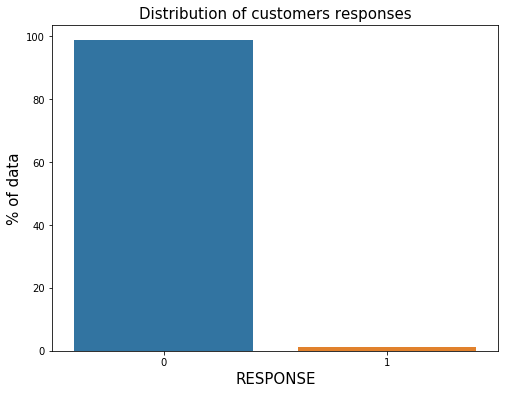

In [6]:
# Split data to features and labels
LABEL = mailout_train_df['RESPONSE']
FEATURES = mailout_train_df.drop('RESPONSE', axis=1)

# Check Count for Response column in Mailout_Train
num_rows = mailout_train_df.shape[0]

# Response values
cout = LABEL.value_counts()
df_sp = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
df_sp['% of data'] = 100 * df_sp['% of data'] / num_rows

# plot data on Response values

plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=df_sp)
plt.rc('xtick', labelsize=25)  
plt.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

In [8]:
# Ratio Calculation
positive_response_ratio = LABEL.value_counts()[1]/LABEL.value_counts()[0]
print ('The positive response to mail campaign ratio is {:.2f}'.format(positive_response_ratio))

The positive response to mail campaign ratio is 0.01


#### Benchmark Model
I shall create a benchmark model. The goal is to train a supervised model and comapre its metrics to our supervised Linear Learner model previously tested on SageMaker .

In [9]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, make_scorer
from sklearn.ensemble import RandomForestClassifier


In [10]:
# randomize the data

def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    
    X2 = X[permutation, :]
    Y2 = Y[permutation]
    
    return X2, Y2


X_train, y_train = randomize(np.asarray(FEATURES), np.asarray(LABEL))

In [11]:
# shape of the dataset
print('Shape of training data :', X_train.shape)
print('Shape of testing data :', mailout_test_df.shape)
print('Shape of y_pridict data :', y_train.shape) 

Shape of training data : (42962, 171)
Shape of testing data : (42833, 171)
Shape of y_pridict data : (42962,)


In [12]:
# Resize the dataset
X_train.resize((42833, 171),refcheck=False)
y_train.resize((42833),refcheck=False)

In [13]:
# shape of the dataset
print('Shape of training data :', X_train.shape)
print('Shape of testing data :', mailout_test_df.shape)
print('Shape of y_pridict data :',y_train.shape)

Shape of training data : (42833, 171)
Shape of testing data : (42833, 171)
Shape of y_pridict data : (42833,)


In [14]:
import time
# Define get_classifier function to fit different classifiers on balanced data
# to find the best performing classifier algorithm
def get_classifier(clf, param_grid, X=X_train, y=y_train):

    # cross validation uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [15]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [16]:
# Select models to use

lor_model = LogisticRegression(random_state=42, solver='liblinear') # LogisticRegression
rfc_model = RandomForestClassifier(n_estimators=10, random_state=42) # RandomForestClassifier
abc_model = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

In [17]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [xgb_model, lor_model, rfc_model, abc_model]:
    best_score, best_est, time_taken = get_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training XGBClassifier :
XGBClassifier
Time taken : 315.62 secs
Best score : 0.6339
****************************************
Training LogisticRegression :
LogisticRegression
Time taken : 12.5 secs
Best score : 0.6562
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 54.93 secs
Best score : 0.5069
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 238.92 secs
Best score : 0.5883
****************************************


In [18]:
# Choose the best model
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est
XGBClassifier,0.633906,315.62,"XGBClassifier(base_score=0.5, booster='gbtree'..."
LogisticRegression,0.656174,12.50,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.506946,54.93,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.588307,238.92,"(DecisionTreeClassifier(class_weight=None, cri..."


In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
# Set Paramaters tunning 

dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid_random = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2',solver='liblinear')

In [21]:
random = RandomizedSearchCV(
    estimator=lr, 
    param_distributions=param_grid_random, 
    cv = 5, 
    n_jobs=-1)

start_time = time.time()
random_result = random.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + 'sec')

Best: 0.987626 using {'max_iter': 120, 'dual': False, 'C': 2.0}
Execution time: 52.89104175567627sec


In [22]:
X_test = mailout_test_df.values.astype('float32')
X_test.shape

(42833, 171)

In [23]:
# predict the target on the test dataset
y_pred = random_result.predict(X_test)
print('\nTarget on test data',y_pred) 


Target on test data [0 0 0 ... 0 0 0]


In [24]:
# Calculation of accuracy
print ('accuracy_score: {:.2%}'.format(accuracy_score(y_train,y_pred )))

# Calculation of f1 score
print ('f1_score: {:.2%}'.format(f1_score(y_train, y_pred)))

# Calculation of recall_score
print ('recall_score: {:.2%}'.format(recall_score(y_train, y_pred)))

# Calculation of precision_score
print ('precision_score: {:.2%}'.format(precision_score(y_train, y_pred)))

accuracy_score: 98.76%
f1_score: 0.00%
recall_score: 0.00%
precision_score: 0.00%


/Users/nyaribomaseru/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nyaribomaseru/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### These scores are very bad. We can see that our model predict 0 number of the pesrons supposed to be in the mail list 
#### (labeled 1). we can improve our model with different techniques as follow:
- Oversample minority class
- Tuning the model

#### The data is higly unbalanced. Below are steps to create a balanced dataset before we do traning and and testing

### Oversample minority class
To compensate imbalance in data we need to resample our data. For this data we use oversampling which can be defined as adding more copies of the minority class. Oversampling can be a good choice when we don’t have enough data to work with. In this project we will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [28]:
# Balance the data

from sklearn.utils import resample

# Separate input features and target
# y = label
# X = features
y = LABEL
X = FEATURES

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# X = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
# separate minority and majority classes
postive_response = X[X.RESPONSE==0]
negative_response = X[X.RESPONSE==1]

# upsample minority
negative_response_upsampled = resample(negative_response,
                          replace=True, # sample with replacement
                          n_samples=len(postive_response), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([postive_response, negative_response_upsampled])

# check new class counts
upsampled.RESPONSE.value_counts()

1    31829
0    31829
Name: RESPONSE, dtype: int64

In [29]:
# Split the Unsampled data to X_train and Y_train set
y_train = upsampled.RESPONSE
X_train = upsampled.drop('RESPONSE', axis=1)

balanced_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
X_feat = balanced_df.drop('RESPONSE', axis=1)#.values.astype('float32')
y_feat = balanced_df.RESPONSE#.values.astype('float32')

In [31]:
# shape of the dataset
print('Shape of training data :', X_feat.shape)
print('Shape of testing data :', mailout_test_df.shape)
print('Shape of y_pridict data :', y_feat.shape) 

Shape of training data : (63658, 171)
Shape of testing data : (42833, 171)
Shape of y_pridict data : (63658,)


In [33]:
test_x = mailout_test_df.values.astype('float32')
test_x.shape

(42833, 171)

In [34]:
# Resize the test_x dataset
test_x.resize((63658, 171),refcheck=False)

In [35]:
# shape of the dataset
print('Shape of training data :', X_feat.shape)
print('Shape of testing data :', test_x.shape)
print('Shape of y_pridict data :', y_feat.shape) 

Shape of training data : (63658, 171)
Shape of testing data : (63658, 171)
Shape of y_pridict data : (63658,)


### Benchmark Model
Find a benchmark model to use 

In [36]:
import time
# Define get_classifier function to fit different classifiers on balanced data
# to find the best performing classifier algorithm
def get_classifier(clf, param_grid, X=X_feat, y=y_feat):

    # cross validation uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [37]:
# Find best classification algorithm
for clf in [xgb_model, lor_model, rfc_model, abc_model]:
    best_score, best_est, time_taken = get_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training XGBClassifier :
XGBClassifier
Time taken : 396.09 secs
Best score : 0.9608
****************************************
Training LogisticRegression :
LogisticRegression
Time taken : 16.84 secs
Best score : 0.7627
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 29.22 secs
Best score : 0.9927
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 244.34 secs
Best score : 0.8209
****************************************


In [38]:
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est
XGBClassifier,0.633906,315.62,"XGBClassifier(base_score=0.5, booster='gbtree'..."
LogisticRegression,0.656174,12.50,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.506946,54.93,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.588307,238.92,"(DecisionTreeClassifier(class_weight=None, cri..."
XGBClassifier,0.960828,396.09,"XGBClassifier(base_score=0.5, booster='gbtree'..."
LogisticRegression,0.762734,16.84,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.992677,29.22,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.820870,244.34,"(DecisionTreeClassifier(class_weight=None, cri..."


In [84]:
unsampled = rfc_model.fit(X=X_feat, y=y_feat)

In [85]:
# predict the target on the test dataset
y_pred = unsampled.predict(test_x)
print('\nTarget on test data',y_pred) 


Target on test data [0 0 0 ... 0 0 0]


In [86]:
# Calculation of accuracy
print ('accuracy_score: {:.2%}'.format(accuracy_score(y_feat,y_pred )))

# Calculation of f1 score
print ('f1_score: {:.2%}'.format(f1_score(y_feat, y_pred)))

# Calculation of recall_score
print ('recall_score: {:.2%}'.format(recall_score(y_feat, y_pred)))

# Calculation of precision_score
print ('precision_score: {:.2%}'.format(precision_score(y_feat, y_pred)))

accuracy_score: 50.00%
f1_score: 0.13%
recall_score: 0.07%
precision_score: 50.00%


### HyperparameterTuner

In [97]:
n_estimators = [200]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5, 10] 
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [98]:
random = RandomizedSearchCV(
    random_state=42,
    estimator=rfc_model, 
    param_distributions=random_grid, 
    n_iter=10,
    verbose=5,
    cv = 5, 
    n_jobs=-1)

start_time = time.time()
rf_random_result = random.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (rf_random_result.best_score_, rf_random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + 'sec')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 59.1min finished


Best: 0.942018 using {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Execution time: 3619.877776861191sec


In [102]:
# Best params
b_random_grid = {'n_estimators': 200, 
                 'min_samples_split': 2, 
                 'min_samples_leaf': 10, 
                 'max_features': 'log2', 
                 'max_depth': 20, 
                 'bootstrap': False}


In [105]:
rfc_final = RandomForestClassifier(n_estimators = 200, 
          min_samples_split = 2, 
          min_samples_leaf = 10, 
          max_features = 'log2', 
          max_depth =20, 
          bootstrap = False)

In [106]:
final_model = rfc_final.fit(X=X_feat, y=y_feat)

In [107]:
# predict the target on the test dataset
y_pred_final = final_model.predict(test_x)
print('\nTarget on test data',y_pred_final) 


Target on test data [0 0 0 ... 0 0 0]


In [108]:
# Calculation of accuracy
print ('accuracy_score: {:.2%}'.format(accuracy_score(y_feat,y_pred_final )))

# Calculation of f1 score
print ('f1_score: {:.2%}'.format(f1_score(y_feat, y_pred_final)))

# Calculation of recall_score
print ('recall_score: {:.2%}'.format(recall_score(y_feat, y_pred_final)))

# Calculation of precision_score
print ('precision_score: {:.2%}'.format(precision_score(y_feat, y_pred_final)))

accuracy_score: 50.00%
f1_score: 0.03%
recall_score: 0.01%
precision_score: 57.14%


In [111]:
# import the metrics class
cnf_matrix = confusion_matrix(y_feat,y_pred_final)
cnf_matrix



# confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, make_score

array([[31826,     3],
       [31825,     4]])

In [112]:
print ('True Positive: {}'.format(cnf_matrix[1][1]))
print ('True Negative: {}'.format(cnf_matrix[0][0]))
print ('False Positive: {}'.format(cnf_matrix[0][1]))
print ('False Negative: {}'.format(cnf_matrix[1][0]))

True Positive: 4
True Negative: 31826
False Positive: 3
False Negative: 31825


In [87]:
lor_unsampled = lor_model.fit(X=X_feat, y=y_feat)

In [88]:
# predict the target on the test dataset
lr_y_pred = lor_unsampled.predict(test_x)
print('\nTarget on test data',lr_y_pred) 


Target on test data [1 1 0 ... 1 0 0]


In [89]:
# Calculation of accuracy
print ('accuracy_score: {:.2%}'.format(accuracy_score(y_feat,lr_y_pred )))

# Calculation of f1 score
print ('f1_score: {:.2%}'.format(f1_score(y_feat, lr_y_pred)))

# Calculation of recall_score
print ('recall_score: {:.2%}'.format(recall_score(y_feat, lr_y_pred)))

# Calculation of precision_score
print ('precision_score: {:.2%}'.format(precision_score(y_feat, lr_y_pred)))

accuracy_score: 49.55%
f1_score: 32.36%
recall_score: 24.14%
precision_score: 49.09%


In [90]:
abc_model_unsampled = abc_model.fit(X=X_feat, y=y_feat)

In [91]:
# predict the target on the test dataset
abc_y_pred = abc_model_unsampled.predict(test_x)
print('\nTarget on test data',abc_y_pred) 


Target on test data [0 0 0 ... 0 0 1]


In [92]:
# Calculation of accuracy
print ('accuracy_score: {:.2%}'.format(accuracy_score(y_feat,abc_y_pred )))

# Calculation of f1 score
print ('f1_score: {:.2%}'.format(f1_score(y_feat, abc_y_pred)))

# Calculation of recall_score
print ('recall_score: {:.2%}'.format(recall_score(y_feat, abc_y_pred)))

# Calculation of precision_score
print ('precision_score: {:.2%}'.format(precision_score(y_feat, abc_y_pred)))

accuracy_score: 50.48%
f1_score: 43.57%
recall_score: 38.24%
precision_score: 50.63%
